# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=150  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=1, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 513 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=256,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
# writer = SummaryWriter()
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.330673, Accuracy: 9.38
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.662550, Accuracy: 11.33
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.490566, Accuracy: 9.38
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.294803, Accuracy: 12.89
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.264874, Accuracy: 13.28
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.276338, Accuracy: 14.45
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.176674, Accuracy: 17.19
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.138515, Accuracy: 14.84
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.073710, Accuracy: 20.31
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.065409, Accuracy: 23.05
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.876233, Accuracy: 24.22
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.944293, Accuracy: 21.48
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.951048, Accuracy: 22.66
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.934011, Accuracy: 22.27
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.829826, Accuracy: 28.91
Train Epoch:

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.008775, Accuracy: 64.06
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.093240, Accuracy: 61.72
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.090421, Accuracy: 61.72
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.223085, Accuracy: 60.55
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.066804, Accuracy: 61.72
Train Epoch: 3 [20480/50000 (45%)]	Loss: 0.968739, Accuracy: 66.80
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.112940, Accuracy: 60.16
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.220196, Accuracy: 61.33
Train Epoch: 3 [24320/50000 (54%)]	Loss: 0.970926, Accuracy: 66.02
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.027514, Accuracy: 65.23
Train Epoch: 3 [26880/50000 (60%)]	Loss: 0.919560, Accuracy: 71.09
Train Epoch: 3 [28160/50000 (62%)]	Loss: 0.965900, Accuracy: 65.62
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.080095, Accuracy: 60.55
Train Epoch: 3 [30720/50000 (68%)]	Loss: 0.973425, Accuracy: 64.06
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.084064, Accuracy: 6

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.877920, Accuracy: 67.58
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.686996, Accuracy: 77.73
Train Epoch: 6 [29440/50000 (65%)]	Loss: 0.787761, Accuracy: 75.78
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.680067, Accuracy: 74.61
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.794986, Accuracy: 71.88
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.695037, Accuracy: 75.78
Train Epoch: 6 [34560/50000 (77%)]	Loss: 0.737055, Accuracy: 74.61
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.712762, Accuracy: 76.95
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.754020, Accuracy: 74.61
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.702142, Accuracy: 74.22
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.697236, Accuracy: 76.56
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.844094, Accuracy: 74.22
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.688116, Accuracy: 77.34
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.709644, Accuracy: 72.66
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.704215, Accuracy: 7

Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.658625, Accuracy: 76.56
Train Epoch: 9 [40960/50000 (91%)]	Loss: 0.596723, Accuracy: 80.47
Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.564574, Accuracy: 79.69
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.562642, Accuracy: 82.42
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.546199, Accuracy: 80.00

Validation set: Average loss: 0.5969, Accuracy: 3980/5000 (79.00%)

the time of this epoch:[20.126267910003662 s]
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.607843, Accuracy: 77.73
Train Epoch: 10 [1280/50000 (3%)]	Loss: 0.719089, Accuracy: 73.05
Train Epoch: 10 [2560/50000 (6%)]	Loss: 0.539565, Accuracy: 80.86
Train Epoch: 10 [3840/50000 (9%)]	Loss: 0.544309, Accuracy: 81.25
Train Epoch: 10 [5120/50000 (11%)]	Loss: 0.537723, Accuracy: 80.08
Train Epoch: 10 [6400/50000 (14%)]	Loss: 0.617551, Accuracy: 78.91
Train Epoch: 10 [7680/50000 (17%)]	Loss: 0.569376, Accuracy: 78.52
Train Epoch: 10 [8960/50000 (20%)]	Loss: 0.530435, Accuracy: 85.16
Train Epoch: 10 [1024

Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.442618, Accuracy: 84.77
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.506149, Accuracy: 82.42
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.481336, Accuracy: 82.03
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.440018, Accuracy: 82.81
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.478978, Accuracy: 83.20
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.438381, Accuracy: 86.33
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.450461, Accuracy: 83.59
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.368425, Accuracy: 86.72
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.412260, Accuracy: 85.16
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.397035, Accuracy: 85.55
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.483485, Accuracy: 85.16
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.492110, Accuracy: 85.94
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.568198, Accuracy: 79.30
Train Epoch: 13 [19200/50000 (43%)]	Loss: 0.416249, Accuracy: 86.33
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.699377, Accu

Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.417045, Accuracy: 85.55
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.521473, Accuracy: 83.59
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.368195, Accuracy: 88.28
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.541393, Accuracy: 79.69
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.385582, Accuracy: 86.72
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.406777, Accuracy: 83.98
Train Epoch: 16 [21760/50000 (48%)]	Loss: 0.454856, Accuracy: 84.38
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.357888, Accuracy: 87.11
Train Epoch: 16 [24320/50000 (54%)]	Loss: 0.446358, Accuracy: 82.42
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.458717, Accuracy: 83.98
Train Epoch: 16 [26880/50000 (60%)]	Loss: 0.402972, Accuracy: 86.33
Train Epoch: 16 [28160/50000 (62%)]	Loss: 0.411055, Accuracy: 85.94
Train Epoch: 16 [29440/50000 (65%)]	Loss: 0.645287, Accuracy: 81.25
Train Epoch: 16 [30720/50000 (68%)]	Loss: 0.456509, Accuracy: 85.55
Train Epoch: 16 [32000/50000 (71%)]	Loss: 0.3652

Train Epoch: 19 [25600/50000 (57%)]	Loss: 0.339458, Accuracy: 91.41
Train Epoch: 19 [26880/50000 (60%)]	Loss: 0.436921, Accuracy: 82.81
Train Epoch: 19 [28160/50000 (62%)]	Loss: 0.345179, Accuracy: 85.55
Train Epoch: 19 [29440/50000 (65%)]	Loss: 0.442195, Accuracy: 85.94
Train Epoch: 19 [30720/50000 (68%)]	Loss: 0.416812, Accuracy: 84.77
Train Epoch: 19 [32000/50000 (71%)]	Loss: 0.435318, Accuracy: 85.55
Train Epoch: 19 [33280/50000 (74%)]	Loss: 0.434090, Accuracy: 83.59
Train Epoch: 19 [34560/50000 (77%)]	Loss: 0.410445, Accuracy: 87.50
Train Epoch: 19 [35840/50000 (80%)]	Loss: 0.354985, Accuracy: 88.28
Train Epoch: 19 [37120/50000 (82%)]	Loss: 0.395976, Accuracy: 85.94
Train Epoch: 19 [38400/50000 (85%)]	Loss: 0.435881, Accuracy: 85.55
Train Epoch: 19 [39680/50000 (88%)]	Loss: 0.448013, Accuracy: 87.11
Train Epoch: 19 [40960/50000 (91%)]	Loss: 0.367985, Accuracy: 88.28
Train Epoch: 19 [42240/50000 (94%)]	Loss: 0.348707, Accuracy: 86.72
Train Epoch: 19 [43520/50000 (97%)]	Loss: 0.4313

Train Epoch: 22 [37120/50000 (82%)]	Loss: 0.270922, Accuracy: 91.41
Train Epoch: 22 [38400/50000 (85%)]	Loss: 0.215077, Accuracy: 91.80
Train Epoch: 22 [39680/50000 (88%)]	Loss: 0.330146, Accuracy: 89.06
Train Epoch: 22 [40960/50000 (91%)]	Loss: 0.237118, Accuracy: 92.97
Train Epoch: 22 [42240/50000 (94%)]	Loss: 0.254585, Accuracy: 91.41
Train Epoch: 22 [43520/50000 (97%)]	Loss: 0.281889, Accuracy: 89.06
Train Epoch: 22 [35000/50000 (99%)]	Loss: 0.318631, Accuracy: 88.50

Validation set: Average loss: 0.4283, Accuracy: 4266/5000 (85.00%)

the time of this epoch:[20.20387315750122 s]
Train Epoch: 23 [0/50000 (0%)]	Loss: 0.193724, Accuracy: 92.58
Train Epoch: 23 [1280/50000 (3%)]	Loss: 0.221770, Accuracy: 91.41
Train Epoch: 23 [2560/50000 (6%)]	Loss: 0.258915, Accuracy: 92.58
Train Epoch: 23 [3840/50000 (9%)]	Loss: 0.238876, Accuracy: 91.02
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.255415, Accuracy: 91.41
Train Epoch: 23 [6400/50000 (14%)]	Loss: 0.286000, Accuracy: 89.45
Train Epoch: 23

Train Epoch: 26 [1280/50000 (3%)]	Loss: 0.181069, Accuracy: 93.75
Train Epoch: 26 [2560/50000 (6%)]	Loss: 0.237052, Accuracy: 92.58
Train Epoch: 26 [3840/50000 (9%)]	Loss: 0.258513, Accuracy: 92.19
Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.198756, Accuracy: 92.97
Train Epoch: 26 [6400/50000 (14%)]	Loss: 0.276945, Accuracy: 90.23
Train Epoch: 26 [7680/50000 (17%)]	Loss: 0.259951, Accuracy: 90.23
Train Epoch: 26 [8960/50000 (20%)]	Loss: 0.174027, Accuracy: 93.75
Train Epoch: 26 [10240/50000 (23%)]	Loss: 0.189927, Accuracy: 93.75
Train Epoch: 26 [11520/50000 (26%)]	Loss: 0.300690, Accuracy: 87.50
Train Epoch: 26 [12800/50000 (28%)]	Loss: 0.231068, Accuracy: 91.80
Train Epoch: 26 [14080/50000 (31%)]	Loss: 0.273070, Accuracy: 89.06
Train Epoch: 26 [15360/50000 (34%)]	Loss: 0.245952, Accuracy: 89.45
Train Epoch: 26 [16640/50000 (37%)]	Loss: 0.267696, Accuracy: 91.02
Train Epoch: 26 [17920/50000 (40%)]	Loss: 0.328003, Accuracy: 89.06
Train Epoch: 26 [19200/50000 (43%)]	Loss: 0.282507, Accura

Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.293354, Accuracy: 88.67
Train Epoch: 29 [14080/50000 (31%)]	Loss: 0.270810, Accuracy: 90.62
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.243696, Accuracy: 91.41
Train Epoch: 29 [16640/50000 (37%)]	Loss: 0.213850, Accuracy: 92.58
Train Epoch: 29 [17920/50000 (40%)]	Loss: 0.268364, Accuracy: 90.62
Train Epoch: 29 [19200/50000 (43%)]	Loss: 0.342824, Accuracy: 88.67
Train Epoch: 29 [20480/50000 (45%)]	Loss: 0.214185, Accuracy: 92.58
Train Epoch: 29 [21760/50000 (48%)]	Loss: 0.243768, Accuracy: 91.41
Train Epoch: 29 [23040/50000 (51%)]	Loss: 0.291908, Accuracy: 90.62
Train Epoch: 29 [24320/50000 (54%)]	Loss: 0.174259, Accuracy: 96.48
Train Epoch: 29 [25600/50000 (57%)]	Loss: 0.234816, Accuracy: 90.23
Train Epoch: 29 [26880/50000 (60%)]	Loss: 0.181434, Accuracy: 94.92
Train Epoch: 29 [28160/50000 (62%)]	Loss: 0.218657, Accuracy: 93.75
Train Epoch: 29 [29440/50000 (65%)]	Loss: 0.220348, Accuracy: 92.97
Train Epoch: 29 [30720/50000 (68%)]	Loss: 0.2251

Train Epoch: 32 [24320/50000 (54%)]	Loss: 0.185590, Accuracy: 93.36
Train Epoch: 32 [25600/50000 (57%)]	Loss: 0.201919, Accuracy: 92.19
Train Epoch: 32 [26880/50000 (60%)]	Loss: 0.184144, Accuracy: 92.19
Train Epoch: 32 [28160/50000 (62%)]	Loss: 0.228446, Accuracy: 91.41
Train Epoch: 32 [29440/50000 (65%)]	Loss: 0.275747, Accuracy: 90.62
Train Epoch: 32 [30720/50000 (68%)]	Loss: 0.287577, Accuracy: 88.67
Train Epoch: 32 [32000/50000 (71%)]	Loss: 0.185988, Accuracy: 94.53
Train Epoch: 32 [33280/50000 (74%)]	Loss: 0.200051, Accuracy: 92.58
Train Epoch: 32 [34560/50000 (77%)]	Loss: 0.298620, Accuracy: 89.45
Train Epoch: 32 [35840/50000 (80%)]	Loss: 0.283705, Accuracy: 89.84
Train Epoch: 32 [37120/50000 (82%)]	Loss: 0.236718, Accuracy: 91.80
Train Epoch: 32 [38400/50000 (85%)]	Loss: 0.213601, Accuracy: 93.36
Train Epoch: 32 [39680/50000 (88%)]	Loss: 0.246496, Accuracy: 89.45
Train Epoch: 32 [40960/50000 (91%)]	Loss: 0.187009, Accuracy: 92.58
Train Epoch: 32 [42240/50000 (94%)]	Loss: 0.1830

Train Epoch: 35 [35840/50000 (80%)]	Loss: 0.226607, Accuracy: 91.41
Train Epoch: 35 [37120/50000 (82%)]	Loss: 0.236357, Accuracy: 92.19
Train Epoch: 35 [38400/50000 (85%)]	Loss: 0.188417, Accuracy: 94.14
Train Epoch: 35 [39680/50000 (88%)]	Loss: 0.211547, Accuracy: 93.36
Train Epoch: 35 [40960/50000 (91%)]	Loss: 0.164934, Accuracy: 95.31
Train Epoch: 35 [42240/50000 (94%)]	Loss: 0.186801, Accuracy: 92.97
Train Epoch: 35 [43520/50000 (97%)]	Loss: 0.194156, Accuracy: 93.75
Train Epoch: 35 [35000/50000 (99%)]	Loss: 0.193755, Accuracy: 93.00

Validation set: Average loss: 0.4321, Accuracy: 4329/5000 (86.00%)

the time of this epoch:[20.030986070632935 s]
Train Epoch: 36 [0/50000 (0%)]	Loss: 0.135235, Accuracy: 94.53
Train Epoch: 36 [1280/50000 (3%)]	Loss: 0.200047, Accuracy: 91.41
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.174891, Accuracy: 93.36
Train Epoch: 36 [3840/50000 (9%)]	Loss: 0.275863, Accuracy: 92.58
Train Epoch: 36 [5120/50000 (11%)]	Loss: 0.243959, Accuracy: 92.97
Train Epoch: 

Train Epoch: 39 [1280/50000 (3%)]	Loss: 0.132616, Accuracy: 95.31
Train Epoch: 39 [2560/50000 (6%)]	Loss: 0.119578, Accuracy: 94.92
Train Epoch: 39 [3840/50000 (9%)]	Loss: 0.165786, Accuracy: 94.53
Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.133834, Accuracy: 95.70
Train Epoch: 39 [6400/50000 (14%)]	Loss: 0.153932, Accuracy: 95.31
Train Epoch: 39 [7680/50000 (17%)]	Loss: 0.226644, Accuracy: 91.02
Train Epoch: 39 [8960/50000 (20%)]	Loss: 0.138448, Accuracy: 94.14
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.236148, Accuracy: 92.19
Train Epoch: 39 [11520/50000 (26%)]	Loss: 0.141239, Accuracy: 94.53
Train Epoch: 39 [12800/50000 (28%)]	Loss: 0.159121, Accuracy: 92.97
Train Epoch: 39 [14080/50000 (31%)]	Loss: 0.142575, Accuracy: 94.53
Train Epoch: 39 [15360/50000 (34%)]	Loss: 0.128398, Accuracy: 94.14
Train Epoch: 39 [16640/50000 (37%)]	Loss: 0.254673, Accuracy: 92.19
Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.180116, Accuracy: 92.58
Train Epoch: 39 [19200/50000 (43%)]	Loss: 0.168362, Accura

Train Epoch: 42 [12800/50000 (28%)]	Loss: 0.088067, Accuracy: 96.09
Train Epoch: 42 [14080/50000 (31%)]	Loss: 0.167011, Accuracy: 94.14
Train Epoch: 42 [15360/50000 (34%)]	Loss: 0.114569, Accuracy: 95.70
Train Epoch: 42 [16640/50000 (37%)]	Loss: 0.221186, Accuracy: 92.97
Train Epoch: 42 [17920/50000 (40%)]	Loss: 0.149763, Accuracy: 94.14
Train Epoch: 42 [19200/50000 (43%)]	Loss: 0.087164, Accuracy: 96.09
Train Epoch: 42 [20480/50000 (45%)]	Loss: 0.138233, Accuracy: 95.70
Train Epoch: 42 [21760/50000 (48%)]	Loss: 0.117325, Accuracy: 94.53
Train Epoch: 42 [23040/50000 (51%)]	Loss: 0.103554, Accuracy: 96.88
Train Epoch: 42 [24320/50000 (54%)]	Loss: 0.185095, Accuracy: 94.53
Train Epoch: 42 [25600/50000 (57%)]	Loss: 0.118262, Accuracy: 95.70
Train Epoch: 42 [26880/50000 (60%)]	Loss: 0.135908, Accuracy: 93.75
Train Epoch: 42 [28160/50000 (62%)]	Loss: 0.182498, Accuracy: 94.92
Train Epoch: 42 [29440/50000 (65%)]	Loss: 0.137221, Accuracy: 94.92
Train Epoch: 42 [30720/50000 (68%)]	Loss: 0.1210

Train Epoch: 45 [24320/50000 (54%)]	Loss: 0.081045, Accuracy: 97.27
Train Epoch: 45 [25600/50000 (57%)]	Loss: 0.115676, Accuracy: 95.70
Train Epoch: 45 [26880/50000 (60%)]	Loss: 0.077588, Accuracy: 96.88
Train Epoch: 45 [28160/50000 (62%)]	Loss: 0.102258, Accuracy: 96.88
Train Epoch: 45 [29440/50000 (65%)]	Loss: 0.150195, Accuracy: 96.09
Train Epoch: 45 [30720/50000 (68%)]	Loss: 0.113347, Accuracy: 96.09
Train Epoch: 45 [32000/50000 (71%)]	Loss: 0.176314, Accuracy: 93.36
Train Epoch: 45 [33280/50000 (74%)]	Loss: 0.061237, Accuracy: 98.44
Train Epoch: 45 [34560/50000 (77%)]	Loss: 0.050772, Accuracy: 98.05
Train Epoch: 45 [35840/50000 (80%)]	Loss: 0.059752, Accuracy: 97.66
Train Epoch: 45 [37120/50000 (82%)]	Loss: 0.139898, Accuracy: 94.92
Train Epoch: 45 [38400/50000 (85%)]	Loss: 0.137980, Accuracy: 94.53
Train Epoch: 45 [39680/50000 (88%)]	Loss: 0.159041, Accuracy: 94.53
Train Epoch: 45 [40960/50000 (91%)]	Loss: 0.131315, Accuracy: 95.70
Train Epoch: 45 [42240/50000 (94%)]	Loss: 0.1084

Train Epoch: 48 [35840/50000 (80%)]	Loss: 0.071025, Accuracy: 96.88
Train Epoch: 48 [37120/50000 (82%)]	Loss: 0.112528, Accuracy: 96.09
Train Epoch: 48 [38400/50000 (85%)]	Loss: 0.114002, Accuracy: 96.48
Train Epoch: 48 [39680/50000 (88%)]	Loss: 0.098424, Accuracy: 95.31
Train Epoch: 48 [40960/50000 (91%)]	Loss: 0.133160, Accuracy: 95.70
Train Epoch: 48 [42240/50000 (94%)]	Loss: 0.068414, Accuracy: 98.05
Train Epoch: 48 [43520/50000 (97%)]	Loss: 0.078624, Accuracy: 96.09
Train Epoch: 48 [35000/50000 (99%)]	Loss: 0.080655, Accuracy: 97.00

Validation set: Average loss: 0.4005, Accuracy: 4436/5000 (88.00%)

the time of this epoch:[20.049903392791748 s]
Train Epoch: 49 [0/50000 (0%)]	Loss: 0.046784, Accuracy: 99.61
Train Epoch: 49 [1280/50000 (3%)]	Loss: 0.094166, Accuracy: 97.66
Train Epoch: 49 [2560/50000 (6%)]	Loss: 0.112850, Accuracy: 96.48
Train Epoch: 49 [3840/50000 (9%)]	Loss: 0.139791, Accuracy: 95.70
Train Epoch: 49 [5120/50000 (11%)]	Loss: 0.109417, Accuracy: 95.31
Train Epoch: 

Train Epoch: 52 [1280/50000 (3%)]	Loss: 0.082521, Accuracy: 96.09
Train Epoch: 52 [2560/50000 (6%)]	Loss: 0.080237, Accuracy: 97.66
Train Epoch: 52 [3840/50000 (9%)]	Loss: 0.086051, Accuracy: 96.88
Train Epoch: 52 [5120/50000 (11%)]	Loss: 0.056064, Accuracy: 98.44
Train Epoch: 52 [6400/50000 (14%)]	Loss: 0.099786, Accuracy: 96.48
Train Epoch: 52 [7680/50000 (17%)]	Loss: 0.072919, Accuracy: 97.66
Train Epoch: 52 [8960/50000 (20%)]	Loss: 0.055711, Accuracy: 98.05
Train Epoch: 52 [10240/50000 (23%)]	Loss: 0.074965, Accuracy: 97.66
Train Epoch: 52 [11520/50000 (26%)]	Loss: 0.093767, Accuracy: 96.88
Train Epoch: 52 [12800/50000 (28%)]	Loss: 0.137297, Accuracy: 95.31
Train Epoch: 52 [14080/50000 (31%)]	Loss: 0.076230, Accuracy: 97.66
Train Epoch: 52 [15360/50000 (34%)]	Loss: 0.078185, Accuracy: 96.48
Train Epoch: 52 [16640/50000 (37%)]	Loss: 0.124946, Accuracy: 94.92
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.071419, Accuracy: 98.05
Train Epoch: 52 [19200/50000 (43%)]	Loss: 0.076815, Accura

Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.103989, Accuracy: 95.31
Train Epoch: 55 [14080/50000 (31%)]	Loss: 0.077899, Accuracy: 97.27
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.095072, Accuracy: 95.31
Train Epoch: 55 [16640/50000 (37%)]	Loss: 0.066700, Accuracy: 97.66
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.087610, Accuracy: 97.66
Train Epoch: 55 [19200/50000 (43%)]	Loss: 0.131969, Accuracy: 97.27
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.094482, Accuracy: 98.05
Train Epoch: 55 [21760/50000 (48%)]	Loss: 0.095220, Accuracy: 97.27
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.073663, Accuracy: 98.05
Train Epoch: 55 [24320/50000 (54%)]	Loss: 0.071620, Accuracy: 97.27
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.062885, Accuracy: 98.05
Train Epoch: 55 [26880/50000 (60%)]	Loss: 0.059521, Accuracy: 98.05
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.145327, Accuracy: 94.53
Train Epoch: 55 [29440/50000 (65%)]	Loss: 0.103702, Accuracy: 97.27
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.1117

Train Epoch: 58 [24320/50000 (54%)]	Loss: 0.144565, Accuracy: 94.53
Train Epoch: 58 [25600/50000 (57%)]	Loss: 0.056967, Accuracy: 98.44
Train Epoch: 58 [26880/50000 (60%)]	Loss: 0.070095, Accuracy: 97.27
Train Epoch: 58 [28160/50000 (62%)]	Loss: 0.115128, Accuracy: 95.31
Train Epoch: 58 [29440/50000 (65%)]	Loss: 0.056901, Accuracy: 98.05
Train Epoch: 58 [30720/50000 (68%)]	Loss: 0.079143, Accuracy: 96.09
Train Epoch: 58 [32000/50000 (71%)]	Loss: 0.067304, Accuracy: 96.88
Train Epoch: 58 [33280/50000 (74%)]	Loss: 0.083223, Accuracy: 96.48
Train Epoch: 58 [34560/50000 (77%)]	Loss: 0.131454, Accuracy: 96.48
Train Epoch: 58 [35840/50000 (80%)]	Loss: 0.081879, Accuracy: 97.66
Train Epoch: 58 [37120/50000 (82%)]	Loss: 0.062731, Accuracy: 98.44
Train Epoch: 58 [38400/50000 (85%)]	Loss: 0.071608, Accuracy: 97.66
Train Epoch: 58 [39680/50000 (88%)]	Loss: 0.102762, Accuracy: 94.92
Train Epoch: 58 [40960/50000 (91%)]	Loss: 0.102605, Accuracy: 96.88
Train Epoch: 58 [42240/50000 (94%)]	Loss: 0.1259

Train Epoch: 61 [35840/50000 (80%)]	Loss: 0.028178, Accuracy: 99.22
Train Epoch: 61 [37120/50000 (82%)]	Loss: 0.088232, Accuracy: 97.66
Train Epoch: 61 [38400/50000 (85%)]	Loss: 0.038118, Accuracy: 98.44
Train Epoch: 61 [39680/50000 (88%)]	Loss: 0.071647, Accuracy: 96.88
Train Epoch: 61 [40960/50000 (91%)]	Loss: 0.113301, Accuracy: 95.31
Train Epoch: 61 [42240/50000 (94%)]	Loss: 0.053691, Accuracy: 98.05
Train Epoch: 61 [43520/50000 (97%)]	Loss: 0.081513, Accuracy: 96.88
Train Epoch: 61 [35000/50000 (99%)]	Loss: 0.105456, Accuracy: 95.50

Validation set: Average loss: 0.4070, Accuracy: 4487/5000 (89.00%)

the time of this epoch:[20.373467922210693 s]
Train Epoch: 62 [0/50000 (0%)]	Loss: 0.060287, Accuracy: 96.88
Train Epoch: 62 [1280/50000 (3%)]	Loss: 0.067258, Accuracy: 97.66
Train Epoch: 62 [2560/50000 (6%)]	Loss: 0.062017, Accuracy: 96.48
Train Epoch: 62 [3840/50000 (9%)]	Loss: 0.030697, Accuracy: 98.83
Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.041170, Accuracy: 99.22
Train Epoch: 

Train Epoch: 65 [1280/50000 (3%)]	Loss: 0.034090, Accuracy: 99.22
Train Epoch: 65 [2560/50000 (6%)]	Loss: 0.065784, Accuracy: 97.66
Train Epoch: 65 [3840/50000 (9%)]	Loss: 0.072536, Accuracy: 96.88
Train Epoch: 65 [5120/50000 (11%)]	Loss: 0.035224, Accuracy: 98.83
Train Epoch: 65 [6400/50000 (14%)]	Loss: 0.047127, Accuracy: 97.66
Train Epoch: 65 [7680/50000 (17%)]	Loss: 0.057017, Accuracy: 98.05
Train Epoch: 65 [8960/50000 (20%)]	Loss: 0.038319, Accuracy: 98.83
Train Epoch: 65 [10240/50000 (23%)]	Loss: 0.042515, Accuracy: 98.05
Train Epoch: 65 [11520/50000 (26%)]	Loss: 0.060764, Accuracy: 98.83
Train Epoch: 65 [12800/50000 (28%)]	Loss: 0.041966, Accuracy: 98.44
Train Epoch: 65 [14080/50000 (31%)]	Loss: 0.034907, Accuracy: 98.05
Train Epoch: 65 [15360/50000 (34%)]	Loss: 0.028011, Accuracy: 98.83
Train Epoch: 65 [16640/50000 (37%)]	Loss: 0.059799, Accuracy: 97.66
Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.044024, Accuracy: 98.05
Train Epoch: 65 [19200/50000 (43%)]	Loss: 0.054965, Accura

Train Epoch: 68 [12800/50000 (28%)]	Loss: 0.027528, Accuracy: 99.22
Train Epoch: 68 [14080/50000 (31%)]	Loss: 0.022594, Accuracy: 99.22
Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.029494, Accuracy: 98.44
Train Epoch: 68 [16640/50000 (37%)]	Loss: 0.055482, Accuracy: 98.44
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.066422, Accuracy: 97.27
Train Epoch: 68 [19200/50000 (43%)]	Loss: 0.071414, Accuracy: 96.88
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.070391, Accuracy: 97.27
Train Epoch: 68 [21760/50000 (48%)]	Loss: 0.044474, Accuracy: 98.05
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.024560, Accuracy: 99.22
Train Epoch: 68 [24320/50000 (54%)]	Loss: 0.038410, Accuracy: 98.44
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.082487, Accuracy: 98.44
Train Epoch: 68 [26880/50000 (60%)]	Loss: 0.022368, Accuracy: 99.22
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.042224, Accuracy: 98.44
Train Epoch: 68 [29440/50000 (65%)]	Loss: 0.087991, Accuracy: 96.09
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.0635

Train Epoch: 71 [24320/50000 (54%)]	Loss: 0.061120, Accuracy: 98.44
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.028428, Accuracy: 98.83
Train Epoch: 71 [26880/50000 (60%)]	Loss: 0.077045, Accuracy: 96.88
Train Epoch: 71 [28160/50000 (62%)]	Loss: 0.030977, Accuracy: 98.83
Train Epoch: 71 [29440/50000 (65%)]	Loss: 0.051400, Accuracy: 98.44
Train Epoch: 71 [30720/50000 (68%)]	Loss: 0.051158, Accuracy: 98.05
Train Epoch: 71 [32000/50000 (71%)]	Loss: 0.048922, Accuracy: 98.83
Train Epoch: 71 [33280/50000 (74%)]	Loss: 0.052556, Accuracy: 98.05
Train Epoch: 71 [34560/50000 (77%)]	Loss: 0.047052, Accuracy: 98.44
Train Epoch: 71 [35840/50000 (80%)]	Loss: 0.040785, Accuracy: 98.44
Train Epoch: 71 [37120/50000 (82%)]	Loss: 0.025659, Accuracy: 98.83
Train Epoch: 71 [38400/50000 (85%)]	Loss: 0.028014, Accuracy: 99.61
Train Epoch: 71 [39680/50000 (88%)]	Loss: 0.079817, Accuracy: 98.05
Train Epoch: 71 [40960/50000 (91%)]	Loss: 0.063900, Accuracy: 97.27
Train Epoch: 71 [42240/50000 (94%)]	Loss: 0.0528

Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.034864, Accuracy: 99.22
Train Epoch: 74 [37120/50000 (82%)]	Loss: 0.040981, Accuracy: 98.05
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.069949, Accuracy: 98.05
Train Epoch: 74 [39680/50000 (88%)]	Loss: 0.047780, Accuracy: 98.83
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.033059, Accuracy: 98.44
Train Epoch: 74 [42240/50000 (94%)]	Loss: 0.051734, Accuracy: 97.66
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.036559, Accuracy: 98.44
Train Epoch: 74 [35000/50000 (99%)]	Loss: 0.037104, Accuracy: 98.50

Validation set: Average loss: 0.4792, Accuracy: 4477/5000 (89.00%)

the time of this epoch:[20.24541926383972 s]
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.026988, Accuracy: 98.44
Train Epoch: 75 [1280/50000 (3%)]	Loss: 0.035946, Accuracy: 98.83
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.046393, Accuracy: 98.44
Train Epoch: 75 [3840/50000 (9%)]	Loss: 0.069719, Accuracy: 98.05
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.040249, Accuracy: 98.44
Train Epoch: 7

Train Epoch: 78 [1280/50000 (3%)]	Loss: 0.023036, Accuracy: 99.22
Train Epoch: 78 [2560/50000 (6%)]	Loss: 0.052995, Accuracy: 98.05
Train Epoch: 78 [3840/50000 (9%)]	Loss: 0.015064, Accuracy: 99.61
Train Epoch: 78 [5120/50000 (11%)]	Loss: 0.034523, Accuracy: 98.44
Train Epoch: 78 [6400/50000 (14%)]	Loss: 0.042940, Accuracy: 98.44
Train Epoch: 78 [7680/50000 (17%)]	Loss: 0.021593, Accuracy: 98.83
Train Epoch: 78 [8960/50000 (20%)]	Loss: 0.027348, Accuracy: 98.44
Train Epoch: 78 [10240/50000 (23%)]	Loss: 0.047174, Accuracy: 98.44
Train Epoch: 78 [11520/50000 (26%)]	Loss: 0.018445, Accuracy: 99.61
Train Epoch: 78 [12800/50000 (28%)]	Loss: 0.054781, Accuracy: 98.05
Train Epoch: 78 [14080/50000 (31%)]	Loss: 0.023005, Accuracy: 98.83
Train Epoch: 78 [15360/50000 (34%)]	Loss: 0.025296, Accuracy: 98.44
Train Epoch: 78 [16640/50000 (37%)]	Loss: 0.028589, Accuracy: 98.83
Train Epoch: 78 [17920/50000 (40%)]	Loss: 0.102127, Accuracy: 96.88
Train Epoch: 78 [19200/50000 (43%)]	Loss: 0.009923, Accura

Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.031053, Accuracy: 98.44
Train Epoch: 81 [14080/50000 (31%)]	Loss: 0.028608, Accuracy: 98.83
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.018378, Accuracy: 99.22
Train Epoch: 81 [16640/50000 (37%)]	Loss: 0.017828, Accuracy: 99.61
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.019957, Accuracy: 98.83
Train Epoch: 81 [19200/50000 (43%)]	Loss: 0.082084, Accuracy: 96.88
Train Epoch: 81 [20480/50000 (45%)]	Loss: 0.044849, Accuracy: 98.05
Train Epoch: 81 [21760/50000 (48%)]	Loss: 0.038139, Accuracy: 98.05
Train Epoch: 81 [23040/50000 (51%)]	Loss: 0.038850, Accuracy: 98.83
Train Epoch: 81 [24320/50000 (54%)]	Loss: 0.029859, Accuracy: 98.83
Train Epoch: 81 [25600/50000 (57%)]	Loss: 0.008559, Accuracy: 99.61
Train Epoch: 81 [26880/50000 (60%)]	Loss: 0.033228, Accuracy: 98.83
Train Epoch: 81 [28160/50000 (62%)]	Loss: 0.021020, Accuracy: 98.83
Train Epoch: 81 [29440/50000 (65%)]	Loss: 0.020729, Accuracy: 99.22
Train Epoch: 81 [30720/50000 (68%)]	Loss: 0.0078

Train Epoch: 84 [23040/50000 (51%)]	Loss: 0.024819, Accuracy: 99.22
Train Epoch: 84 [24320/50000 (54%)]	Loss: 0.056179, Accuracy: 98.05
Train Epoch: 84 [25600/50000 (57%)]	Loss: 0.028176, Accuracy: 98.83
Train Epoch: 84 [26880/50000 (60%)]	Loss: 0.078625, Accuracy: 96.88
Train Epoch: 84 [28160/50000 (62%)]	Loss: 0.009431, Accuracy: 100.00
Train Epoch: 84 [29440/50000 (65%)]	Loss: 0.011592, Accuracy: 99.61
Train Epoch: 84 [30720/50000 (68%)]	Loss: 0.026825, Accuracy: 98.83
Train Epoch: 84 [32000/50000 (71%)]	Loss: 0.021068, Accuracy: 98.83
Train Epoch: 84 [33280/50000 (74%)]	Loss: 0.052503, Accuracy: 97.66
Train Epoch: 84 [34560/50000 (77%)]	Loss: 0.012838, Accuracy: 99.61
Train Epoch: 84 [35840/50000 (80%)]	Loss: 0.031941, Accuracy: 99.22
Train Epoch: 84 [37120/50000 (82%)]	Loss: 0.008745, Accuracy: 100.00
Train Epoch: 84 [38400/50000 (85%)]	Loss: 0.030751, Accuracy: 99.22
Train Epoch: 84 [39680/50000 (88%)]	Loss: 0.013288, Accuracy: 99.61
Train Epoch: 84 [40960/50000 (91%)]	Loss: 0.02

Train Epoch: 87 [33280/50000 (74%)]	Loss: 0.053246, Accuracy: 98.44
Train Epoch: 87 [34560/50000 (77%)]	Loss: 0.020457, Accuracy: 99.22
Train Epoch: 87 [35840/50000 (80%)]	Loss: 0.033602, Accuracy: 98.83
Train Epoch: 87 [37120/50000 (82%)]	Loss: 0.023658, Accuracy: 99.22
Train Epoch: 87 [38400/50000 (85%)]	Loss: 0.042371, Accuracy: 98.83
Train Epoch: 87 [39680/50000 (88%)]	Loss: 0.020305, Accuracy: 99.61
Train Epoch: 87 [40960/50000 (91%)]	Loss: 0.011688, Accuracy: 99.61
Train Epoch: 87 [42240/50000 (94%)]	Loss: 0.021948, Accuracy: 99.22
Train Epoch: 87 [43520/50000 (97%)]	Loss: 0.027222, Accuracy: 99.61
Train Epoch: 87 [35000/50000 (99%)]	Loss: 0.018145, Accuracy: 99.50

Validation set: Average loss: 0.5020, Accuracy: 4482/5000 (89.00%)

the time of this epoch:[20.14387607574463 s]
Train Epoch: 88 [0/50000 (0%)]	Loss: 0.003557, Accuracy: 100.00
Train Epoch: 88 [1280/50000 (3%)]	Loss: 0.042293, Accuracy: 98.83
Train Epoch: 88 [2560/50000 (6%)]	Loss: 0.053570, Accuracy: 98.44
Train Epoc

Train Epoch: 90 [43520/50000 (97%)]	Loss: 0.022695, Accuracy: 99.22
Train Epoch: 90 [35000/50000 (99%)]	Loss: 0.012869, Accuracy: 99.50

Validation set: Average loss: 0.5139, Accuracy: 4491/5000 (89.00%)

the time of this epoch:[20.002018213272095 s]
Train Epoch: 91 [0/50000 (0%)]	Loss: 0.015676, Accuracy: 99.22
Train Epoch: 91 [1280/50000 (3%)]	Loss: 0.021696, Accuracy: 99.22
Train Epoch: 91 [2560/50000 (6%)]	Loss: 0.023970, Accuracy: 99.22
Train Epoch: 91 [3840/50000 (9%)]	Loss: 0.007201, Accuracy: 100.00
Train Epoch: 91 [5120/50000 (11%)]	Loss: 0.008187, Accuracy: 100.00
Train Epoch: 91 [6400/50000 (14%)]	Loss: 0.029176, Accuracy: 98.83
Train Epoch: 91 [7680/50000 (17%)]	Loss: 0.015236, Accuracy: 99.22
Train Epoch: 91 [8960/50000 (20%)]	Loss: 0.008041, Accuracy: 99.61
Train Epoch: 91 [10240/50000 (23%)]	Loss: 0.022511, Accuracy: 99.61
Train Epoch: 91 [11520/50000 (26%)]	Loss: 0.022243, Accuracy: 98.83
Train Epoch: 91 [12800/50000 (28%)]	Loss: 0.030784, Accuracy: 98.83
Train Epoch: 9

Train Epoch: 94 [6400/50000 (14%)]	Loss: 0.035747, Accuracy: 99.61
Train Epoch: 94 [7680/50000 (17%)]	Loss: 0.014966, Accuracy: 99.61
Train Epoch: 94 [8960/50000 (20%)]	Loss: 0.046049, Accuracy: 98.83
Train Epoch: 94 [10240/50000 (23%)]	Loss: 0.019416, Accuracy: 99.61
Train Epoch: 94 [11520/50000 (26%)]	Loss: 0.011946, Accuracy: 99.61
Train Epoch: 94 [12800/50000 (28%)]	Loss: 0.016150, Accuracy: 99.22
Train Epoch: 94 [14080/50000 (31%)]	Loss: 0.011652, Accuracy: 100.00
Train Epoch: 94 [15360/50000 (34%)]	Loss: 0.031865, Accuracy: 99.22
Train Epoch: 94 [16640/50000 (37%)]	Loss: 0.004970, Accuracy: 100.00
Train Epoch: 94 [17920/50000 (40%)]	Loss: 0.023713, Accuracy: 99.22
Train Epoch: 94 [19200/50000 (43%)]	Loss: 0.020398, Accuracy: 99.61
Train Epoch: 94 [20480/50000 (45%)]	Loss: 0.016523, Accuracy: 99.22
Train Epoch: 94 [21760/50000 (48%)]	Loss: 0.005740, Accuracy: 100.00
Train Epoch: 94 [23040/50000 (51%)]	Loss: 0.025657, Accuracy: 98.83
Train Epoch: 94 [24320/50000 (54%)]	Loss: 0.0094

Train Epoch: 97 [16640/50000 (37%)]	Loss: 0.019656, Accuracy: 99.22
Train Epoch: 97 [17920/50000 (40%)]	Loss: 0.035883, Accuracy: 98.44
Train Epoch: 97 [19200/50000 (43%)]	Loss: 0.007800, Accuracy: 100.00
Train Epoch: 97 [20480/50000 (45%)]	Loss: 0.032779, Accuracy: 98.44
Train Epoch: 97 [21760/50000 (48%)]	Loss: 0.026499, Accuracy: 99.22
Train Epoch: 97 [23040/50000 (51%)]	Loss: 0.021163, Accuracy: 99.61
Train Epoch: 97 [24320/50000 (54%)]	Loss: 0.028886, Accuracy: 99.22
Train Epoch: 97 [25600/50000 (57%)]	Loss: 0.026725, Accuracy: 98.83
Train Epoch: 97 [26880/50000 (60%)]	Loss: 0.016411, Accuracy: 99.22
Train Epoch: 97 [28160/50000 (62%)]	Loss: 0.050060, Accuracy: 98.05
Train Epoch: 97 [29440/50000 (65%)]	Loss: 0.015679, Accuracy: 99.61
Train Epoch: 97 [30720/50000 (68%)]	Loss: 0.021682, Accuracy: 98.83
Train Epoch: 97 [32000/50000 (71%)]	Loss: 0.013975, Accuracy: 99.22
Train Epoch: 97 [33280/50000 (74%)]	Loss: 0.009389, Accuracy: 99.61
Train Epoch: 97 [34560/50000 (77%)]	Loss: 0.034

Train Epoch: 100 [26880/50000 (60%)]	Loss: 0.015666, Accuracy: 99.61
Train Epoch: 100 [28160/50000 (62%)]	Loss: 0.042700, Accuracy: 98.05
Train Epoch: 100 [29440/50000 (65%)]	Loss: 0.016242, Accuracy: 99.61
Train Epoch: 100 [30720/50000 (68%)]	Loss: 0.012578, Accuracy: 99.22
Train Epoch: 100 [32000/50000 (71%)]	Loss: 0.017710, Accuracy: 99.61
Train Epoch: 100 [33280/50000 (74%)]	Loss: 0.036059, Accuracy: 98.05
Train Epoch: 100 [34560/50000 (77%)]	Loss: 0.013726, Accuracy: 100.00
Train Epoch: 100 [35840/50000 (80%)]	Loss: 0.037329, Accuracy: 99.22
Train Epoch: 100 [37120/50000 (82%)]	Loss: 0.015873, Accuracy: 100.00
Train Epoch: 100 [38400/50000 (85%)]	Loss: 0.022519, Accuracy: 99.22
Train Epoch: 100 [39680/50000 (88%)]	Loss: 0.007589, Accuracy: 100.00
Train Epoch: 100 [40960/50000 (91%)]	Loss: 0.050206, Accuracy: 97.66
Train Epoch: 100 [42240/50000 (94%)]	Loss: 0.013173, Accuracy: 99.61
Train Epoch: 100 [43520/50000 (97%)]	Loss: 0.005347, Accuracy: 100.00
Train Epoch: 100 [35000/50000 

Train Epoch: 103 [35840/50000 (80%)]	Loss: 0.006322, Accuracy: 99.61
Train Epoch: 103 [37120/50000 (82%)]	Loss: 0.004920, Accuracy: 100.00
Train Epoch: 103 [38400/50000 (85%)]	Loss: 0.016526, Accuracy: 99.61
Train Epoch: 103 [39680/50000 (88%)]	Loss: 0.009132, Accuracy: 99.61
Train Epoch: 103 [40960/50000 (91%)]	Loss: 0.010679, Accuracy: 99.22
Train Epoch: 103 [42240/50000 (94%)]	Loss: 0.009211, Accuracy: 99.61
Train Epoch: 103 [43520/50000 (97%)]	Loss: 0.013223, Accuracy: 100.00
Train Epoch: 103 [35000/50000 (99%)]	Loss: 0.015970, Accuracy: 99.50

Validation set: Average loss: 0.5315, Accuracy: 4487/5000 (89.00%)

the time of this epoch:[19.664073944091797 s]
Train Epoch: 104 [0/50000 (0%)]	Loss: 0.014870, Accuracy: 99.61
Train Epoch: 104 [1280/50000 (3%)]	Loss: 0.009107, Accuracy: 99.61
Train Epoch: 104 [2560/50000 (6%)]	Loss: 0.030478, Accuracy: 98.83
Train Epoch: 104 [3840/50000 (9%)]	Loss: 0.005184, Accuracy: 99.61
Train Epoch: 104 [5120/50000 (11%)]	Loss: 0.004749, Accuracy: 100.

Train Epoch: 106 [43520/50000 (97%)]	Loss: 0.005463, Accuracy: 99.61
Train Epoch: 106 [35000/50000 (99%)]	Loss: 0.017072, Accuracy: 99.50

Validation set: Average loss: 0.5408, Accuracy: 4490/5000 (89.00%)

the time of this epoch:[19.551984548568726 s]
Train Epoch: 107 [0/50000 (0%)]	Loss: 0.010431, Accuracy: 100.00
Train Epoch: 107 [1280/50000 (3%)]	Loss: 0.003325, Accuracy: 100.00
Train Epoch: 107 [2560/50000 (6%)]	Loss: 0.008092, Accuracy: 100.00
Train Epoch: 107 [3840/50000 (9%)]	Loss: 0.027030, Accuracy: 99.61
Train Epoch: 107 [5120/50000 (11%)]	Loss: 0.006305, Accuracy: 100.00
Train Epoch: 107 [6400/50000 (14%)]	Loss: 0.008526, Accuracy: 99.61
Train Epoch: 107 [7680/50000 (17%)]	Loss: 0.037918, Accuracy: 98.83
Train Epoch: 107 [8960/50000 (20%)]	Loss: 0.022350, Accuracy: 99.61
Train Epoch: 107 [10240/50000 (23%)]	Loss: 0.019673, Accuracy: 98.83
Train Epoch: 107 [11520/50000 (26%)]	Loss: 0.005276, Accuracy: 100.00
Train Epoch: 107 [12800/50000 (28%)]	Loss: 0.003143, Accuracy: 100.

Train Epoch: 110 [3840/50000 (9%)]	Loss: 0.021821, Accuracy: 99.22
Train Epoch: 110 [5120/50000 (11%)]	Loss: 0.026903, Accuracy: 98.83
Train Epoch: 110 [6400/50000 (14%)]	Loss: 0.017214, Accuracy: 99.61
Train Epoch: 110 [7680/50000 (17%)]	Loss: 0.004338, Accuracy: 100.00
Train Epoch: 110 [8960/50000 (20%)]	Loss: 0.027014, Accuracy: 98.83
Train Epoch: 110 [10240/50000 (23%)]	Loss: 0.026377, Accuracy: 98.83
Train Epoch: 110 [11520/50000 (26%)]	Loss: 0.008440, Accuracy: 100.00
Train Epoch: 110 [12800/50000 (28%)]	Loss: 0.040481, Accuracy: 98.05
Train Epoch: 110 [14080/50000 (31%)]	Loss: 0.020618, Accuracy: 99.61
Train Epoch: 110 [15360/50000 (34%)]	Loss: 0.022437, Accuracy: 98.83
Train Epoch: 110 [16640/50000 (37%)]	Loss: 0.029474, Accuracy: 98.83
Train Epoch: 110 [17920/50000 (40%)]	Loss: 0.007626, Accuracy: 100.00
Train Epoch: 110 [19200/50000 (43%)]	Loss: 0.008954, Accuracy: 99.61
Train Epoch: 110 [20480/50000 (45%)]	Loss: 0.011354, Accuracy: 99.61
Train Epoch: 110 [21760/50000 (48%)]	

Train Epoch: 113 [12800/50000 (28%)]	Loss: 0.006696, Accuracy: 99.61
Train Epoch: 113 [14080/50000 (31%)]	Loss: 0.003607, Accuracy: 100.00
Train Epoch: 113 [15360/50000 (34%)]	Loss: 0.001684, Accuracy: 100.00
Train Epoch: 113 [16640/50000 (37%)]	Loss: 0.041001, Accuracy: 98.83
Train Epoch: 113 [17920/50000 (40%)]	Loss: 0.021679, Accuracy: 99.61
Train Epoch: 113 [19200/50000 (43%)]	Loss: 0.005201, Accuracy: 100.00
Train Epoch: 113 [20480/50000 (45%)]	Loss: 0.010919, Accuracy: 99.61
Train Epoch: 113 [21760/50000 (48%)]	Loss: 0.026280, Accuracy: 99.22
Train Epoch: 113 [23040/50000 (51%)]	Loss: 0.002464, Accuracy: 100.00
Train Epoch: 113 [24320/50000 (54%)]	Loss: 0.009814, Accuracy: 99.61
Train Epoch: 113 [25600/50000 (57%)]	Loss: 0.058695, Accuracy: 98.44
Train Epoch: 113 [26880/50000 (60%)]	Loss: 0.007569, Accuracy: 100.00
Train Epoch: 113 [28160/50000 (62%)]	Loss: 0.009567, Accuracy: 99.61
Train Epoch: 113 [29440/50000 (65%)]	Loss: 0.029432, Accuracy: 98.83
Train Epoch: 113 [30720/50000

Train Epoch: 116 [20480/50000 (45%)]	Loss: 0.007183, Accuracy: 99.61
Train Epoch: 116 [21760/50000 (48%)]	Loss: 0.009675, Accuracy: 99.61
Train Epoch: 116 [23040/50000 (51%)]	Loss: 0.018439, Accuracy: 99.22
Train Epoch: 116 [24320/50000 (54%)]	Loss: 0.009410, Accuracy: 99.61
Train Epoch: 116 [25600/50000 (57%)]	Loss: 0.004418, Accuracy: 100.00
Train Epoch: 116 [26880/50000 (60%)]	Loss: 0.039868, Accuracy: 98.05
Train Epoch: 116 [28160/50000 (62%)]	Loss: 0.008177, Accuracy: 100.00
Train Epoch: 116 [29440/50000 (65%)]	Loss: 0.007923, Accuracy: 100.00
Train Epoch: 116 [30720/50000 (68%)]	Loss: 0.017452, Accuracy: 99.22
Train Epoch: 116 [32000/50000 (71%)]	Loss: 0.020896, Accuracy: 99.61
Train Epoch: 116 [33280/50000 (74%)]	Loss: 0.019385, Accuracy: 99.61
Train Epoch: 116 [34560/50000 (77%)]	Loss: 0.019307, Accuracy: 98.83
Train Epoch: 116 [35840/50000 (80%)]	Loss: 0.004192, Accuracy: 100.00
Train Epoch: 116 [37120/50000 (82%)]	Loss: 0.017783, Accuracy: 99.61
Train Epoch: 116 [38400/50000 

Train Epoch: 119 [28160/50000 (62%)]	Loss: 0.020843, Accuracy: 98.83
Train Epoch: 119 [29440/50000 (65%)]	Loss: 0.002858, Accuracy: 100.00
Train Epoch: 119 [30720/50000 (68%)]	Loss: 0.005609, Accuracy: 100.00
Train Epoch: 119 [32000/50000 (71%)]	Loss: 0.004023, Accuracy: 100.00
Train Epoch: 119 [33280/50000 (74%)]	Loss: 0.037373, Accuracy: 98.83
Train Epoch: 119 [34560/50000 (77%)]	Loss: 0.018574, Accuracy: 99.61
Train Epoch: 119 [35840/50000 (80%)]	Loss: 0.035563, Accuracy: 99.22
Train Epoch: 119 [37120/50000 (82%)]	Loss: 0.001913, Accuracy: 100.00
Train Epoch: 119 [38400/50000 (85%)]	Loss: 0.004742, Accuracy: 100.00
Train Epoch: 119 [39680/50000 (88%)]	Loss: 0.020818, Accuracy: 99.22
Train Epoch: 119 [40960/50000 (91%)]	Loss: 0.006313, Accuracy: 100.00
Train Epoch: 119 [42240/50000 (94%)]	Loss: 0.015090, Accuracy: 99.22
Train Epoch: 119 [43520/50000 (97%)]	Loss: 0.033778, Accuracy: 99.22
Train Epoch: 119 [35000/50000 (99%)]	Loss: 0.006084, Accuracy: 100.00

Validation set: Average lo

Train Epoch: 122 [35840/50000 (80%)]	Loss: 0.014196, Accuracy: 99.22
Train Epoch: 122 [37120/50000 (82%)]	Loss: 0.021562, Accuracy: 99.22
Train Epoch: 122 [38400/50000 (85%)]	Loss: 0.013511, Accuracy: 99.22
Train Epoch: 122 [39680/50000 (88%)]	Loss: 0.020556, Accuracy: 99.22
Train Epoch: 122 [40960/50000 (91%)]	Loss: 0.021667, Accuracy: 99.22
Train Epoch: 122 [42240/50000 (94%)]	Loss: 0.025443, Accuracy: 99.22
Train Epoch: 122 [43520/50000 (97%)]	Loss: 0.011753, Accuracy: 99.22
Train Epoch: 122 [35000/50000 (99%)]	Loss: 0.014691, Accuracy: 99.50

Validation set: Average loss: 0.5695, Accuracy: 4498/5000 (89.00%)

the time of this epoch:[19.722721576690674 s]
Train Epoch: 123 [0/50000 (0%)]	Loss: 0.061574, Accuracy: 97.27
Train Epoch: 123 [1280/50000 (3%)]	Loss: 0.005565, Accuracy: 99.61
Train Epoch: 123 [2560/50000 (6%)]	Loss: 0.007222, Accuracy: 99.61
Train Epoch: 123 [3840/50000 (9%)]	Loss: 0.011358, Accuracy: 99.61
Train Epoch: 123 [5120/50000 (11%)]	Loss: 0.006098, Accuracy: 100.00

Train Epoch: 125 [43520/50000 (97%)]	Loss: 0.001440, Accuracy: 100.00
Train Epoch: 125 [35000/50000 (99%)]	Loss: 0.008033, Accuracy: 100.00

Validation set: Average loss: 0.5656, Accuracy: 4500/5000 (90.00%)

the time of this epoch:[19.127503156661987 s]
Train Epoch: 126 [0/50000 (0%)]	Loss: 0.002710, Accuracy: 100.00
Train Epoch: 126 [1280/50000 (3%)]	Loss: 0.016625, Accuracy: 99.22
Train Epoch: 126 [2560/50000 (6%)]	Loss: 0.001011, Accuracy: 100.00
Train Epoch: 126 [3840/50000 (9%)]	Loss: 0.017613, Accuracy: 99.22
Train Epoch: 126 [5120/50000 (11%)]	Loss: 0.004800, Accuracy: 100.00
Train Epoch: 126 [6400/50000 (14%)]	Loss: 0.003722, Accuracy: 100.00
Train Epoch: 126 [7680/50000 (17%)]	Loss: 0.007961, Accuracy: 99.61
Train Epoch: 126 [8960/50000 (20%)]	Loss: 0.047819, Accuracy: 98.83
Train Epoch: 126 [10240/50000 (23%)]	Loss: 0.022964, Accuracy: 98.83
Train Epoch: 126 [11520/50000 (26%)]	Loss: 0.003063, Accuracy: 100.00
Train Epoch: 126 [12800/50000 (28%)]	Loss: 0.010075, Accuracy: 99

Train Epoch: 129 [3840/50000 (9%)]	Loss: 0.023122, Accuracy: 98.83
Train Epoch: 129 [5120/50000 (11%)]	Loss: 0.030303, Accuracy: 98.83
Train Epoch: 129 [6400/50000 (14%)]	Loss: 0.005760, Accuracy: 99.61
Train Epoch: 129 [7680/50000 (17%)]	Loss: 0.016055, Accuracy: 99.22
Train Epoch: 129 [8960/50000 (20%)]	Loss: 0.006823, Accuracy: 99.61
Train Epoch: 129 [10240/50000 (23%)]	Loss: 0.016394, Accuracy: 99.61
Train Epoch: 129 [11520/50000 (26%)]	Loss: 0.007040, Accuracy: 99.61
Train Epoch: 129 [12800/50000 (28%)]	Loss: 0.007426, Accuracy: 99.61
Train Epoch: 129 [14080/50000 (31%)]	Loss: 0.011783, Accuracy: 99.61
Train Epoch: 129 [15360/50000 (34%)]	Loss: 0.021928, Accuracy: 98.83
Train Epoch: 129 [16640/50000 (37%)]	Loss: 0.008449, Accuracy: 100.00
Train Epoch: 129 [17920/50000 (40%)]	Loss: 0.004334, Accuracy: 100.00
Train Epoch: 129 [19200/50000 (43%)]	Loss: 0.028024, Accuracy: 98.44
Train Epoch: 129 [20480/50000 (45%)]	Loss: 0.005336, Accuracy: 100.00
Train Epoch: 129 [21760/50000 (48%)]	

Train Epoch: 132 [12800/50000 (28%)]	Loss: 0.009251, Accuracy: 99.61
Train Epoch: 132 [14080/50000 (31%)]	Loss: 0.030612, Accuracy: 98.83
Train Epoch: 132 [15360/50000 (34%)]	Loss: 0.019941, Accuracy: 98.83
Train Epoch: 132 [16640/50000 (37%)]	Loss: 0.009039, Accuracy: 99.61
Train Epoch: 132 [17920/50000 (40%)]	Loss: 0.006481, Accuracy: 100.00
Train Epoch: 132 [19200/50000 (43%)]	Loss: 0.003896, Accuracy: 100.00
Train Epoch: 132 [20480/50000 (45%)]	Loss: 0.008619, Accuracy: 100.00
Train Epoch: 132 [21760/50000 (48%)]	Loss: 0.016860, Accuracy: 99.22
Train Epoch: 132 [23040/50000 (51%)]	Loss: 0.029548, Accuracy: 99.22
Train Epoch: 132 [24320/50000 (54%)]	Loss: 0.001523, Accuracy: 100.00
Train Epoch: 132 [25600/50000 (57%)]	Loss: 0.002264, Accuracy: 100.00
Train Epoch: 132 [26880/50000 (60%)]	Loss: 0.002542, Accuracy: 100.00
Train Epoch: 132 [28160/50000 (62%)]	Loss: 0.022740, Accuracy: 99.22
Train Epoch: 132 [29440/50000 (65%)]	Loss: 0.005231, Accuracy: 100.00
Train Epoch: 132 [30720/500

Train Epoch: 135 [20480/50000 (45%)]	Loss: 0.002964, Accuracy: 100.00
Train Epoch: 135 [21760/50000 (48%)]	Loss: 0.010828, Accuracy: 99.61
Train Epoch: 135 [23040/50000 (51%)]	Loss: 0.017519, Accuracy: 99.61
Train Epoch: 135 [24320/50000 (54%)]	Loss: 0.009897, Accuracy: 99.61
Train Epoch: 135 [25600/50000 (57%)]	Loss: 0.001968, Accuracy: 100.00
Train Epoch: 135 [26880/50000 (60%)]	Loss: 0.027253, Accuracy: 98.83
Train Epoch: 135 [28160/50000 (62%)]	Loss: 0.012110, Accuracy: 99.61
Train Epoch: 135 [29440/50000 (65%)]	Loss: 0.001646, Accuracy: 100.00
Train Epoch: 135 [30720/50000 (68%)]	Loss: 0.006051, Accuracy: 100.00
Train Epoch: 135 [32000/50000 (71%)]	Loss: 0.006970, Accuracy: 99.61
Train Epoch: 135 [33280/50000 (74%)]	Loss: 0.004243, Accuracy: 100.00
Train Epoch: 135 [34560/50000 (77%)]	Loss: 0.009146, Accuracy: 99.22
Train Epoch: 135 [35840/50000 (80%)]	Loss: 0.017609, Accuracy: 99.22
Train Epoch: 135 [37120/50000 (82%)]	Loss: 0.001100, Accuracy: 100.00
Train Epoch: 135 [38400/5000

Train Epoch: 138 [28160/50000 (62%)]	Loss: 0.002197, Accuracy: 100.00
Train Epoch: 138 [29440/50000 (65%)]	Loss: 0.023102, Accuracy: 99.22
Train Epoch: 138 [30720/50000 (68%)]	Loss: 0.004341, Accuracy: 99.61
Train Epoch: 138 [32000/50000 (71%)]	Loss: 0.011570, Accuracy: 99.61
Train Epoch: 138 [33280/50000 (74%)]	Loss: 0.026021, Accuracy: 98.83
Train Epoch: 138 [34560/50000 (77%)]	Loss: 0.002054, Accuracy: 100.00
Train Epoch: 138 [35840/50000 (80%)]	Loss: 0.006632, Accuracy: 100.00
Train Epoch: 138 [37120/50000 (82%)]	Loss: 0.011615, Accuracy: 99.61
Train Epoch: 138 [38400/50000 (85%)]	Loss: 0.004764, Accuracy: 99.61
Train Epoch: 138 [39680/50000 (88%)]	Loss: 0.043463, Accuracy: 98.83
Train Epoch: 138 [40960/50000 (91%)]	Loss: 0.011147, Accuracy: 99.61
Train Epoch: 138 [42240/50000 (94%)]	Loss: 0.013044, Accuracy: 99.61
Train Epoch: 138 [43520/50000 (97%)]	Loss: 0.003716, Accuracy: 100.00
Train Epoch: 138 [35000/50000 (99%)]	Loss: 0.007814, Accuracy: 100.00

Validation set: Average loss

Train Epoch: 141 [35840/50000 (80%)]	Loss: 0.042823, Accuracy: 99.22
Train Epoch: 141 [37120/50000 (82%)]	Loss: 0.001542, Accuracy: 100.00
Train Epoch: 141 [38400/50000 (85%)]	Loss: 0.003551, Accuracy: 100.00
Train Epoch: 141 [39680/50000 (88%)]	Loss: 0.014798, Accuracy: 99.61
Train Epoch: 141 [40960/50000 (91%)]	Loss: 0.004044, Accuracy: 100.00
Train Epoch: 141 [42240/50000 (94%)]	Loss: 0.012069, Accuracy: 99.22
Train Epoch: 141 [43520/50000 (97%)]	Loss: 0.006341, Accuracy: 100.00
Train Epoch: 141 [35000/50000 (99%)]	Loss: 0.072932, Accuracy: 98.00

Validation set: Average loss: 0.5902, Accuracy: 4509/5000 (90.00%)

the time of this epoch:[19.456239223480225 s]
Train Epoch: 142 [0/50000 (0%)]	Loss: 0.012577, Accuracy: 99.22
Train Epoch: 142 [1280/50000 (3%)]	Loss: 0.008505, Accuracy: 99.61
Train Epoch: 142 [2560/50000 (6%)]	Loss: 0.011037, Accuracy: 99.61
Train Epoch: 142 [3840/50000 (9%)]	Loss: 0.008521, Accuracy: 99.61
Train Epoch: 142 [5120/50000 (11%)]	Loss: 0.004016, Accuracy: 10

Train Epoch: 144 [43520/50000 (97%)]	Loss: 0.007270, Accuracy: 100.00
Train Epoch: 144 [35000/50000 (99%)]	Loss: 0.001357, Accuracy: 100.00

Validation set: Average loss: 0.5903, Accuracy: 4503/5000 (90.00%)

the time of this epoch:[19.563012838363647 s]
Train Epoch: 145 [0/50000 (0%)]	Loss: 0.002447, Accuracy: 100.00
Train Epoch: 145 [1280/50000 (3%)]	Loss: 0.005875, Accuracy: 100.00
Train Epoch: 145 [2560/50000 (6%)]	Loss: 0.025737, Accuracy: 99.22
Train Epoch: 145 [3840/50000 (9%)]	Loss: 0.023392, Accuracy: 98.83
Train Epoch: 145 [5120/50000 (11%)]	Loss: 0.002602, Accuracy: 100.00
Train Epoch: 145 [6400/50000 (14%)]	Loss: 0.012322, Accuracy: 99.22
Train Epoch: 145 [7680/50000 (17%)]	Loss: 0.005247, Accuracy: 100.00
Train Epoch: 145 [8960/50000 (20%)]	Loss: 0.017578, Accuracy: 99.22
Train Epoch: 145 [10240/50000 (23%)]	Loss: 0.008479, Accuracy: 99.61
Train Epoch: 145 [11520/50000 (26%)]	Loss: 0.037299, Accuracy: 98.05
Train Epoch: 145 [12800/50000 (28%)]	Loss: 0.017256, Accuracy: 98.

Train Epoch: 148 [3840/50000 (9%)]	Loss: 0.001659, Accuracy: 100.00
Train Epoch: 148 [5120/50000 (11%)]	Loss: 0.016150, Accuracy: 99.22
Train Epoch: 148 [6400/50000 (14%)]	Loss: 0.006853, Accuracy: 100.00
Train Epoch: 148 [7680/50000 (17%)]	Loss: 0.001973, Accuracy: 100.00
Train Epoch: 148 [8960/50000 (20%)]	Loss: 0.007582, Accuracy: 99.61
Train Epoch: 148 [10240/50000 (23%)]	Loss: 0.005473, Accuracy: 99.61
Train Epoch: 148 [11520/50000 (26%)]	Loss: 0.031359, Accuracy: 99.61
Train Epoch: 148 [12800/50000 (28%)]	Loss: 0.015308, Accuracy: 99.22
Train Epoch: 148 [14080/50000 (31%)]	Loss: 0.005861, Accuracy: 99.61
Train Epoch: 148 [15360/50000 (34%)]	Loss: 0.001618, Accuracy: 100.00
Train Epoch: 148 [16640/50000 (37%)]	Loss: 0.003102, Accuracy: 100.00
Train Epoch: 148 [17920/50000 (40%)]	Loss: 0.006771, Accuracy: 99.61
Train Epoch: 148 [19200/50000 (43%)]	Loss: 0.006162, Accuracy: 99.61
Train Epoch: 148 [20480/50000 (45%)]	Loss: 0.005520, Accuracy: 100.00
Train Epoch: 148 [21760/50000 (48%

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.7008, Accuracy: 8941/10000 (89.41%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

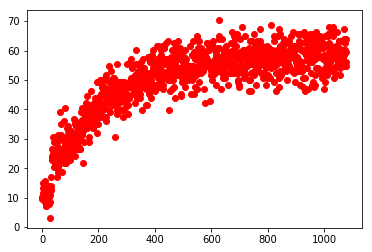

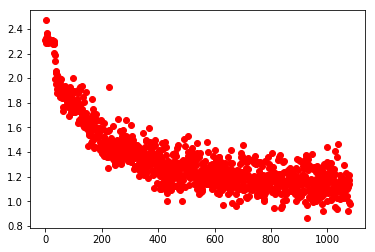

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

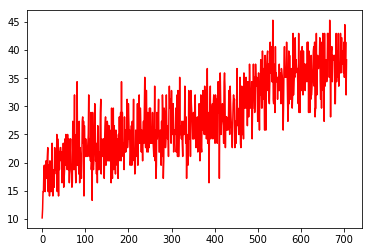

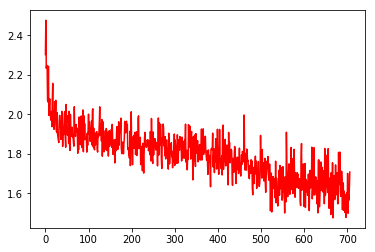

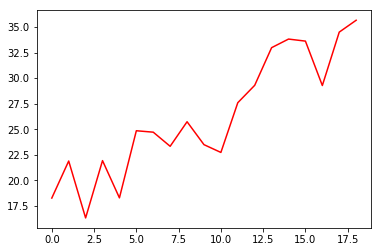

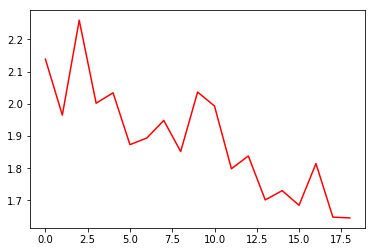

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()